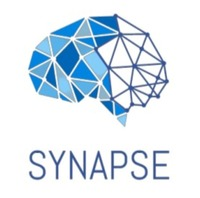

This is a Bonus Hard Tier Task. It is not mandatory to complete the task, but doing this task will give you brownie points in the selection process and learn more into the ever-growing field of ML.

In this notebook we are going to build a simple LSTM model to predict the prices of a stock based on its market history

In [2]:
# Import required Libraries
! pip install yfinance
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential
import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=f32f1bf00964c2e5aeef47b965dd5e625eb4ba69203c9e9acfcef04fd5f6ff67
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


2024-08-07 17:08:14.496008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 17:08:14.496117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 17:08:14.627642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [4]:
data = load_data('TCS.NS') # Load the stock data of Apple since 2010
df=data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,377.399994,379.450012,374.524994,375.825012,283.379211,1963682
1,2010-01-05,377.500000,379.774994,373.274994,375.924988,283.454620,2014488
2,2010-01-06,375.924988,376.100006,366.500000,367.424988,277.045349,3349176
3,2010-01-07,367.750000,369.700012,355.500000,357.200012,269.335663,6474892
4,2010-01-08,358.000000,359.250000,348.250000,349.899994,263.831299,6048178


In [5]:
# Since we only need the Close Column so drop all other columns
df =  df.drop((i for i in ['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume']) , axis = 1) # complete this line
df

,Close
0,375.825012
1,375.924988
2,367.424988
3,357.200012
4,349.899994
...,...
3595,4385.350098
3596,4397.100098
3597,4283.049805
3598,4155.049805


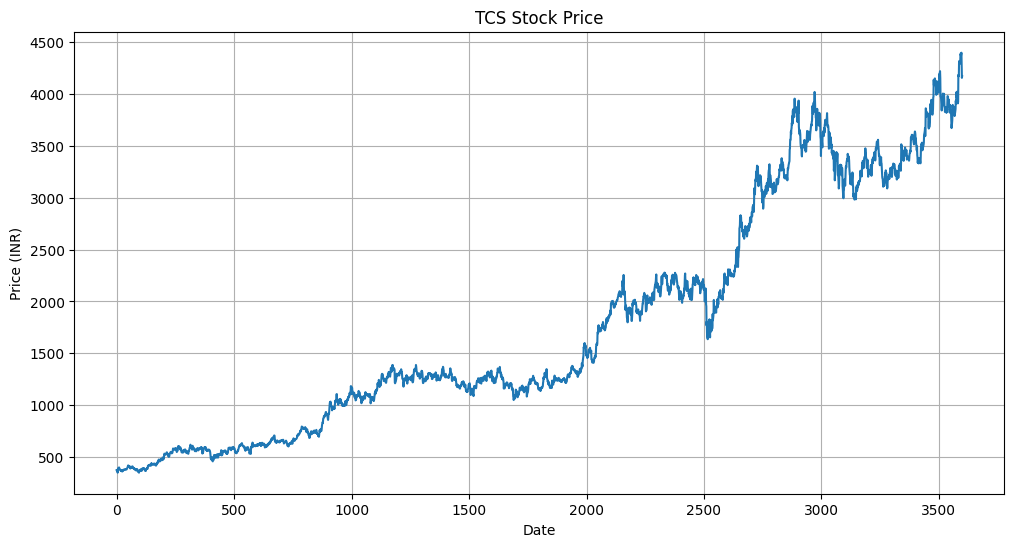

In [6]:
# Plotting the stock price of TCS since 2010

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("TCS Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

Now we need to normalize the data in the Dataframe
You can use MinMax Scaler to normalize the data

Resource:
1. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler

2. https://www.datacamp.com/tutorial/normalization-in-machine-learning

In [7]:
# Normalizaing the values in the Dataframe

#code here
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()

scaled_values = df.copy()

scaled_values['Close'] = MMscaler.fit_transform(np.array(scaled_values['Close']).reshape(-1, 1))
scaled_values

,Close
0,0.006436
1,0.006461
2,0.004361
3,0.001835
4,0.000031
...,...
3595,0.997097
3596,1.000000
3597,0.971821
3598,0.940195


In [8]:
# Now we split our data into train and test so we can evaluate our model's performance after training
train = scaled_values[:int(scaled_values.shape[0] * 0.70)]
test = scaled_values[int(scaled_values.shape[0] * 0.70):]

train.shape[0]

2520

Now we need to modify and train data in such a way that we will be able to feed it into our model

In [9]:
# creating train data such that it can be feeded into the LSTM model, observe why there are 100 inputs 'x' for a single output 'y'
x_train = []
y_train = []
for i in range(100,train.shape[0]):
    x_train.append(train[i-100:i])
    y_train.append(train[i:0])
x_train  = np.array(x_train)
y_train = np.array(y_train)

Now we need to define our model
The Architectue of our model is as follows:

Input layer -> LSTM Layer 1 -> Dropout Layer -> LSTM Layer 2 -> Dropout Layer -> LSTM Layer 3 -> Droput Layer -> LSTM Layer 4 -> Dropout Layer -> Output Layer

Hints:
1. https://keras.io/api/layers/recurrent_layers/lstm/  

2. https://www.kaggle.com/code/kmkarakaya/keras-lstm-explained-in-details
       
3. https://youtu.be/YCzL96nL7j0

In [10]:
# code here
input_layer = Input(shape = (x_train.shape[0], 1))

lstm = LSTM(units = 50, return_sequences = True)(input_layer)
lstm = Dropout(0.2)(lstm)
lstm = LSTM(units = 50, return_sequences = True)(lstm)
lstm = Dropout(0.2)(lstm)
lstm = LSTM(units = 50, return_sequences = True)(lstm)
lstm = Dropout(0.2)(lstm)
lstm = LSTM(units = 50, return_sequences = True)(lstm)
lstm = Dropout(0.2)(lstm)

# Define your model here

output_layer = Dense(units = 50, activation = 'linear')(lstm)
model = keras.Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2420, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 2420, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2420, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 2420, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2420, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 2420, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2420, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 2420, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2420, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2420, 50)       │         2,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,550 (287.30 KB)

 Trainable params: 73,550 (287.30 KB)

 Non-trainable params: 0 (0.00 B)

Loss Funtion resources:
1. https://keras.io/api/losses/

2. https://youtu.be/QBbC3Cjsnjg

3. https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error') # complete this line set the optimized as Adam, and a Loss fucnction you can decide which loss fucntion to use
model.fit(x_train, y_train, epochs = 50) # fill in the x_train,x_test data along with the number of epochs

Epoch 1/50


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 2420, 1), found shape=(None, 100)

To predict the data from out LSTM model we need last 100 sequences from our training data to predict the 1st value in the Test data, create a new array which contains last 100 values of the training data and all of the values of the testing data

In [ ]:
to_predict = # code here

Just as we did for the training data, convert the testing data into a format such that we can feed it into out LSTM model to get predictions

In [ ]:
x_test = []
y_test = []

# code here


In [ ]:
y_pred = model.predict(x_test)

Now we have the predicted values of out test data, but if you notice one thing, the data is between 0-1 because we had normalised the data before, now we need to scale the data back up to its orignal values

In [ ]:
# complete both the lines below, y_test and y_pred should be equal to the scaled-up values
y_test =
y_pred =

Plotting the Orignal and the Precited price by our model

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Your graph should look like this, if not try changing the parameters of you LSTM model

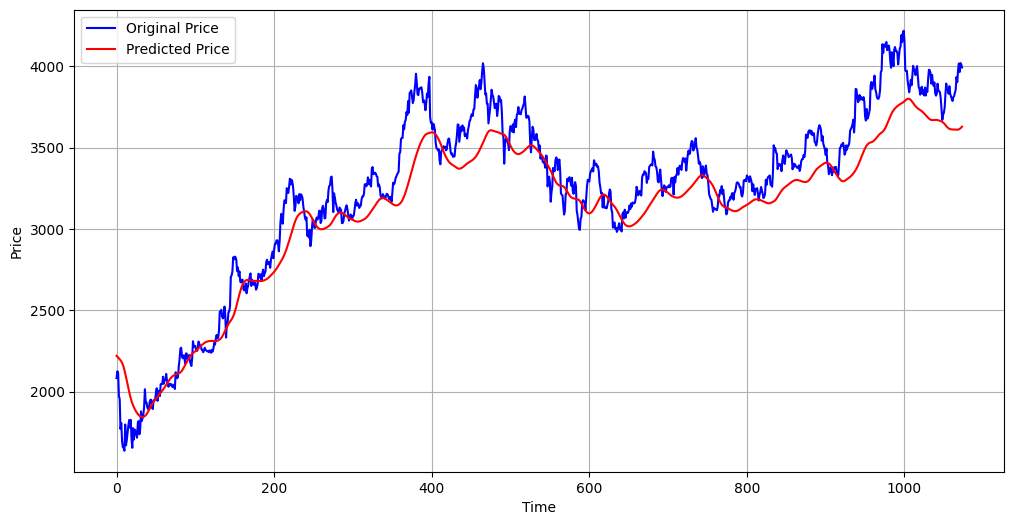

As you can see above our model was fairly able to precit the value of the stock, but how do we quantify how good the predictions are, this is where model evaluation comes into the picture.

In [ ]:
# Calculate the Mean Absolute Error of our model

# code here

In [ ]:
#complete the lines below to calculate the R2 Score of our model
actual =

predicted =

r2 =

print("R2 score:", r2)

Plotting the R2 Score

In [ ]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

Your Graph should look like this

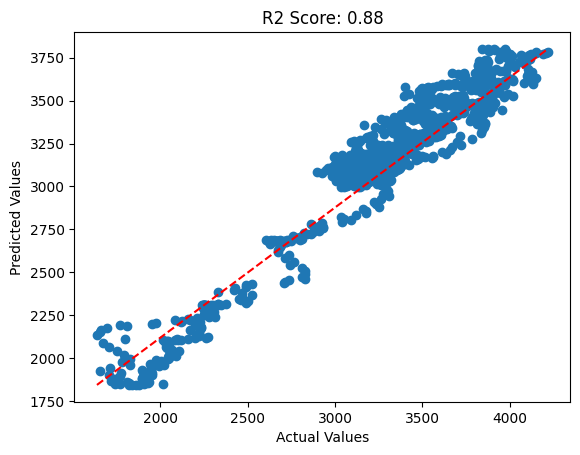

For any doubts contact:

Atharv Mendhe: +918454993809

Hirali Sangani: +919167574134